# Particle Visualization Demo / 粒子可视化演示

本 Notebook 专注于展示 mesh geodesic sampling 生成的粒子可视化效果。

## CLI 参数配置 / CLI Parameter Configuration

在运行之前，请根据您的需求调整以下参数：

**注意**: 新版本的 MeshGeodesicSampler 不再使用 `min_distance` 参数，采样距离由 `expected_particle_size` 自动控制。


In [1]:
# =============================================================================
# CLI 参数配置 / CLI Parameter Configuration
# =============================================================================

# 输入文件配置 / Input File Configuration
  # 设置为 None 使用合成数据，或提供 .mrc 文件路径
INPUT_MASK_FILE = '/home/muwang/Documents/projects/IR/20230518IR_mCherry/memseg_output_frames1_2_10A/rec_pinkss_MGS002_T2_ts_001_px10_MemBrain_seg_v10_beta.ckpt_segmented.mrc'
# INPUT_MASK_FILE = "/path/to/your/membrane_mask.mrc"
#INPUT_MASK_FILE = None
# 采样参数 / Sampling Parameters
SMOOTHING_SIGMA = 1.5        # 高斯平滑参数
TAUBIN_ITERATIONS = 10       # Taubin 平滑迭代次数
PARTICLE_RADIUS = 10.0       # 粒子半径 (用于边界检查)
EXPECTED_PARTICLE_SIZE = 20  # 预期粒子大小 (像素)，None 使用默认值
# 注意: 采样距离由 expected_particle_size 自动控制，约为 particle_size/2
RANDOM_SEED = 42             # 随机种子，None 为确定性
ADD_NOISE = False            # 是否添加噪声到平滑掩码 (用于生成mesh变体)
NOISE_SCALE_FACTOR = 0.1     # 噪声缩放因子 (相对于smoothing_sigma)

# 输出配置 / Output Configuration
OUTPUT_DIR = "../results/particle_visualization_demo"
TOMOGRAM_NAME = "demo_tomo"
PARTICLE_DIAMETER = 200.0   # 粒子直径 (埃)
CREATE_VIS_SCRIPT = True     # 是否创建可视化脚本
USE_SUBTOMOGRAM_FORMAT = True  # 是否使用 RELION 5 subtomogram 格式

# 可视化参数 / Visualization Parameters
MAX_POINTS_PLOT = 5000       # 最大显示点数
NUM_ARROWS = 800            # 箭头数量
ARROW_SCALE_FRAC = 0.05     # 箭头缩放比例
CONE_RADIUS_FRAC = 0.01     # 锥体半径比例
MARKER_SIZE = 2.0           # 标记大小
SHOW_SHAFTS = True          # 是否显示箭头杆
SHAFT_WIDTH = 2.0           # 箭头杆宽度
SHAFT_COLOR = 'red'         # 箭头杆颜色

# ChimeraX 可视化参数 / ChimeraX Visualization Parameters
SPHERE_RADIUS = 2.0         # 球体半径
ARROW_LENGTH = 10.0        # 箭头长度
COORDINATE_SCALE = 1.0     # 坐标缩放
ARROW_AXIS = 'z'           # 箭头轴方向
SPHERE_COLOR = 'cornflower blue'  # 球体颜色
ARROW_COLOR = 'orangered'  # 箭头颜色

print("✅ CLI 参数配置完成 / CLI parameters configured")


✅ CLI 参数配置完成 / CLI parameters configured


In [2]:
# =============================================================================
# 导入库和设置 / Import Libraries and Setup
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D

# TomoPANDA 核心模块
from tomopanda.core.mesh_geodesic import (
    create_mesh_geodesic_sampler,
    generate_synthetic_mask,
    run_mesh_geodesic_sampling,
    save_sampling_outputs,
)

# 工具模块
from tomopanda.utils.mrc_utils import MRCReader
from tomopanda.utils.chimerax_export import write_cxc_for_particles
from tomopanda.utils.relion_utils import read_star, parse_particles_from_star, RELIONConverter

# 设置随机种子
np.random.seed(42)
print("✅ 库导入完成 / Libraries imported successfully")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
✅ 库导入完成 / Libraries imported successfully


📁 加载膜掩码文件 / Loading membrane mask: /home/muwang/Documents/projects/IR/20230518IR_mCherry/memseg_output_frames1_2_10A/rec_pinkss_MGS002_T2_ts_001_px10_MemBrain_seg_v10_beta.ckpt_segmented.mrc
   形状 / Shape: (335, 671, 671)
   数据类型 / Data type: uint8
   非零像素数 / Non-zero pixels: 2945498
✅ 数据加载完成 / Data loading completed
📊 生成 MRC 掩码可视化 / Generating MRC mask visualization


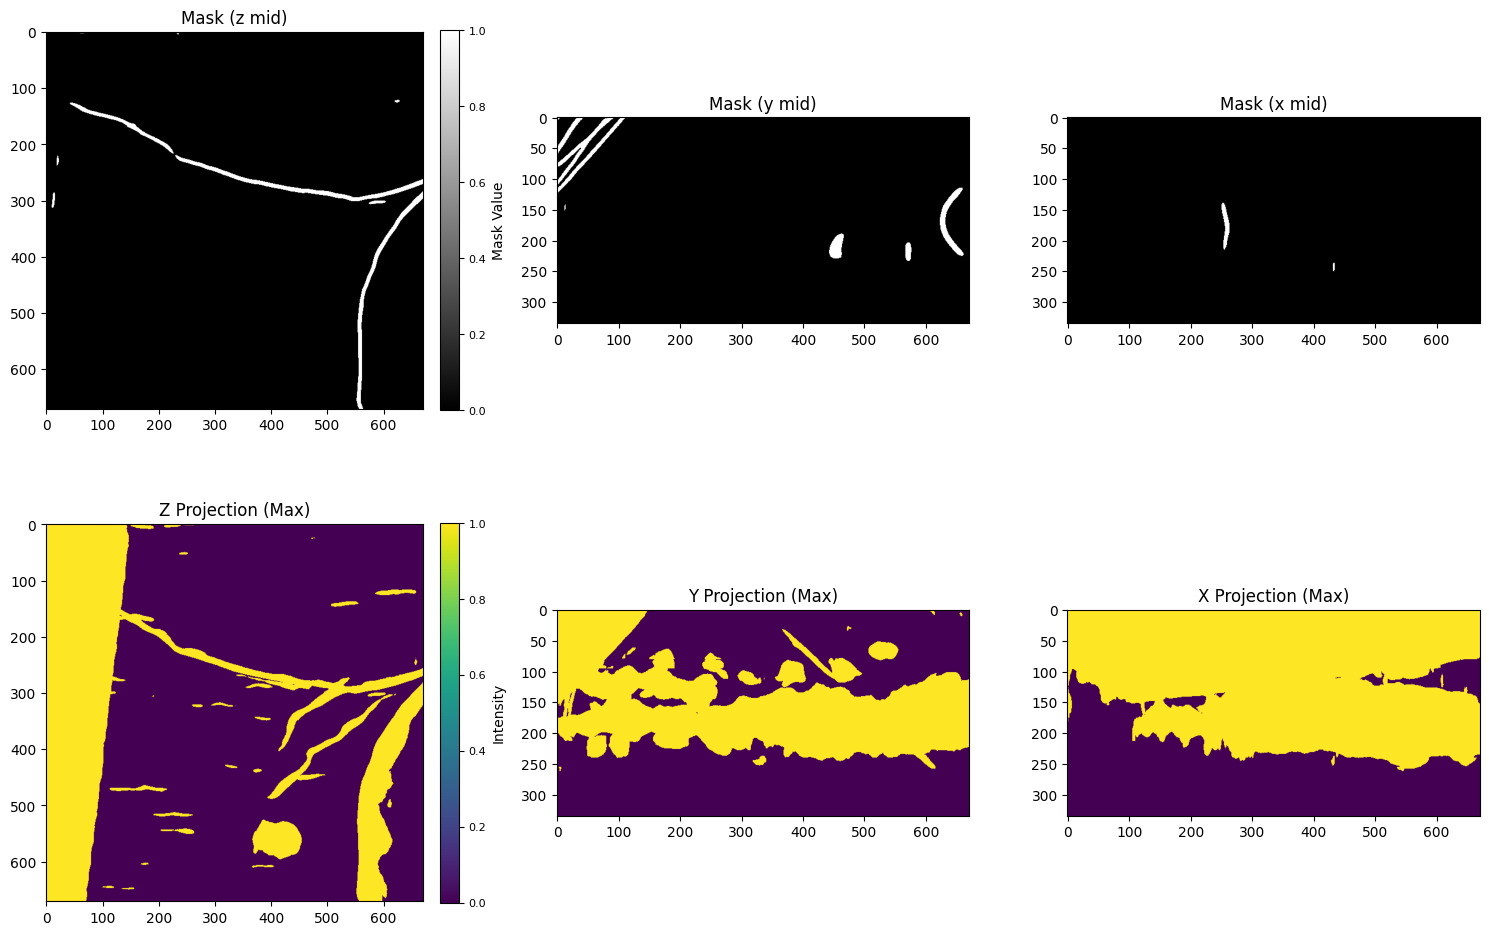

✅ MRC 掩码可视化完成 / MRC mask visualization completed
   掩码形状 / Mask shape: (335, 671, 671)
   非零像素 / Non-zero pixels: 2945498
   填充率 / Fill ratio: 1.95%


In [3]:
# =============================================================================
# 数据加载 / Data Loading
# =============================================================================

if INPUT_MASK_FILE is not None and Path(INPUT_MASK_FILE).exists():
    print(f"📁 加载膜掩码文件 / Loading membrane mask: {INPUT_MASK_FILE}")
    mask = MRCReader.read_membrane_mask(INPUT_MASK_FILE)
    print(f"   形状 / Shape: {mask.shape}")
    print(f"   数据类型 / Data type: {mask.dtype}")
    print(f"   非零像素数 / Non-zero pixels: {mask.sum()}")
else:
    print("🔧 生成合成球形掩码 / Generating synthetic spherical mask")
    mask = generate_synthetic_mask(
        shape=(100, 100, 100),  # (z, y, x)
        center=(50, 50, 50),
        radius=30,
    )
    print(f"   形状 / Shape: {mask.shape}")
    print(f"   非零像素数 / Non-zero pixels: {mask.sum()}")

print("✅ 数据加载完成 / Data loading completed")

# =============================================================================
# MRC 掩码可视化 / MRC Mask Visualization
# =============================================================================

print("📊 生成 MRC 掩码可视化 / Generating MRC mask visualization")

# 创建掩码的中央切片可视化
z, y, x = np.array(mask.shape)
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# 第一行: 掩码切片，灰度显示
for i, (data, title) in enumerate([
    (mask[z//2], 'Mask (z mid)'),
    (mask[:, y//2, :], 'Mask (y mid)'),
    (mask[:, :, x//2], 'Mask (x mid)'),
]):
    im = axs[0, i].imshow(data, cmap='gray')
    axs[0, i].set_title(title, fontsize=12)
    if i == 0:
        # 添加颜色条
        cbar = fig.colorbar(im, ax=axs[0, i], orientation='vertical', fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)
        cbar.set_label('Mask Value', fontsize=10)

# 第二行: 掩码的3D投影（最大强度投影）
from matplotlib.colors import TwoSlopeNorm

# Z方向投影
z_proj = np.max(mask, axis=0)
axs[1, 0].imshow(z_proj, cmap='viridis')
axs[1, 0].set_title('Z Projection (Max)', fontsize=12)

# Y方向投影  
y_proj = np.max(mask, axis=1)
axs[1, 1].imshow(y_proj, cmap='viridis')
axs[1, 1].set_title('Y Projection (Max)', fontsize=12)

# X方向投影
x_proj = np.max(mask, axis=2)
axs[1, 2].imshow(x_proj, cmap='viridis')
axs[1, 2].set_title('X Projection (Max)', fontsize=12)

# 添加颜色条到第二行
cbar = fig.colorbar(axs[1, 0].images[0], ax=axs[1, 0], orientation='vertical', fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)
cbar.set_label('Intensity', fontsize=10)

plt.tight_layout()
plt.show()

print(f"✅ MRC 掩码可视化完成 / MRC mask visualization completed")
print(f"   掩码形状 / Mask shape: {mask.shape}")
print(f"   非零像素 / Non-zero pixels: {mask.sum()}")
print(f"   填充率 / Fill ratio: {mask.sum() / mask.size * 100:.2f}%")


🔬 生成签名距离场 (SDF) / Generating Signed Distance Field (SDF)
📊 生成 SDF 可视化 / Generating SDF visualization


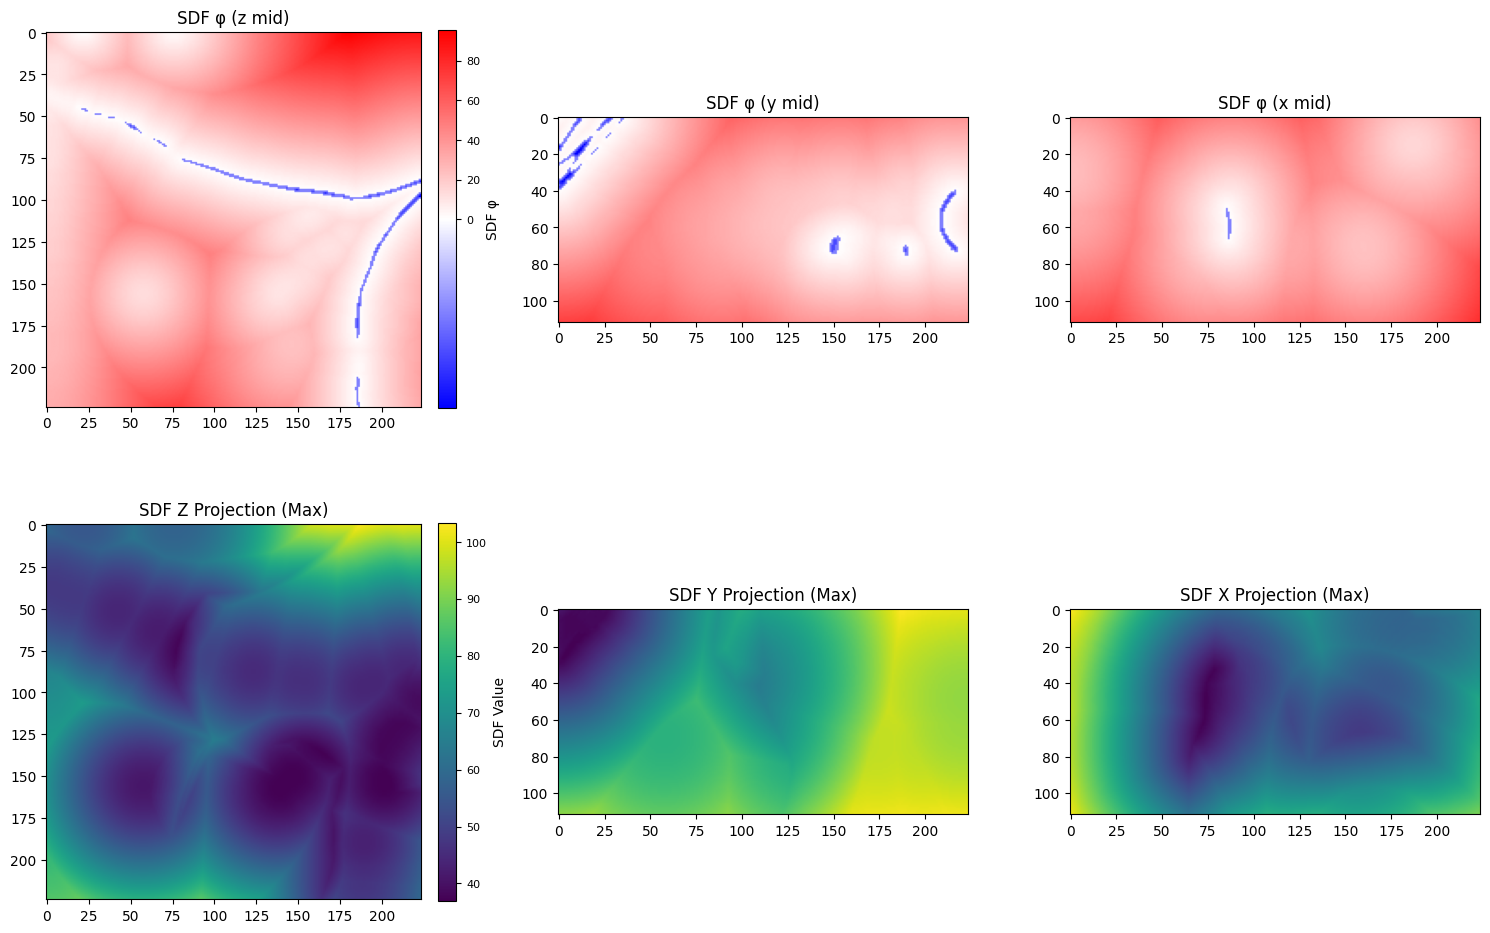

✅ SDF 生成完成 / SDF generation completed
   SDF 形状 / SDF shape: (112, 224, 224)
   SDF 范围 / SDF range: [-3.74, 103.32]
   零等值面像素数 / Zero level set pixels: 0
   负值像素数 / Negative pixels: 69323
   正值像素数 / Positive pixels: 5550389
🔺 从 SDF 提取三角网格 / Extracting triangular mesh from SDF
✅ 网格提取完成 / Mesh extraction completed
   顶点数 / Number of vertices: 101188
   面数 / Number of faces: 199578
   顶点坐标范围 / Vertex coordinate ranges:
     X: [0.04, 445.91]
     Y: [0.05, 445.99]
     Z: [0.05, 167.12]
   三角形面积统计 / Triangle area statistics:
     平均面积 / Mean area: 1.1997
     面积标准差 / Area std: 0.5176
     最小面积 / Min area: 0.0000
     最大面积 / Max area: 3.2161
🚀 开始 Mesh Geodesic 采样 / Starting Mesh Geodesic Sampling
Using mesh face sampling with SDF-aligned normals...
✅ 采样完成 / Sampling completed
   采样点数 / Number of sampled points: 842
   法向量数 / Number of normals: 842
   坐标范围 / Coordinate range:
     X: [10.10, 445.40]
     Y: [10.42, 445.60]
     Z: [10.01, 165.89]
   法向量统计 / Normal vector statistics:
     平均

In [4]:
# =============================================================================
# SDF 生成和可视化 / SDF Generation and Visualization
# =============================================================================

print("🔬 生成签名距离场 (SDF) / Generating Signed Distance Field (SDF)")

# 创建采样器并生成 SDF
# 注意: expected_particle_size 和 taubin_iterations 是互斥的
if EXPECTED_PARTICLE_SIZE is not None:
    # 使用 expected_particle_size (taubin_iterations 会自动计算)
    sampler = create_mesh_geodesic_sampler(
        smoothing_sigma=SMOOTHING_SIGMA,
        expected_particle_size=EXPECTED_PARTICLE_SIZE,
        random_seed=RANDOM_SEED,
        add_noise=ADD_NOISE,
        noise_scale_factor=NOISE_SCALE_FACTOR,
    )
else:
    # 使用手动指定的 taubin_iterations
    sampler = create_mesh_geodesic_sampler(
        smoothing_sigma=SMOOTHING_SIGMA,
        taubin_iterations=TAUBIN_ITERATIONS,
        random_seed=RANDOM_SEED,
        add_noise=ADD_NOISE,
        noise_scale_factor=NOISE_SCALE_FACTOR,
    )

# 生成 SDF
phi = sampler.create_signed_distance_field(mask)

print("📊 生成 SDF 可视化 / Generating SDF visualization")

# 创建 SDF 的中央切片可视化
z, y, x = np.array(phi.shape)
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# 第一行: SDF 切片，使用发散色彩映射
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm

# 自定义发散色彩映射: 负值为蓝色，0为白色，正值为红色
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'custom_div',
    [(0.0, 'blue'), (0.5, 'white'), (1.0, 'red')]
)
norm = TwoSlopeNorm(vcenter=0)

for i, (data, title) in enumerate([
    (phi[z//2], 'SDF φ (z mid)'),
    (phi[:, y//2, :], 'SDF φ (y mid)'),
    (phi[:, :, x//2], 'SDF φ (x mid)'),
]):
    im = axs[0, i].imshow(data, cmap=cmap, norm=norm)
    axs[0, i].set_title(title, fontsize=12)
    if i == 0:
        # 添加颜色条
        cbar = fig.colorbar(im, ax=axs[0, i], orientation='vertical', fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)
        cbar.set_label('SDF φ', fontsize=10)

# 第二行: SDF 的3D投影
# Z方向投影
z_proj = np.max(phi, axis=0)
axs[1, 0].imshow(z_proj, cmap='viridis')
axs[1, 0].set_title('SDF Z Projection (Max)', fontsize=12)

# Y方向投影
y_proj = np.max(phi, axis=1)
axs[1, 1].imshow(y_proj, cmap='viridis')
axs[1, 1].set_title('SDF Y Projection (Max)', fontsize=12)

# X方向投影
x_proj = np.max(phi, axis=2)
axs[1, 2].imshow(x_proj, cmap='viridis')
axs[1, 2].set_title('SDF X Projection (Max)', fontsize=12)

# 添加颜色条到第二行
cbar = fig.colorbar(axs[1, 0].images[0], ax=axs[1, 0], orientation='vertical', fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)
cbar.set_label('SDF Value', fontsize=10)

plt.tight_layout()
plt.show()

# SDF 统计信息
print(f"✅ SDF 生成完成 / SDF generation completed")
print(f"   SDF 形状 / SDF shape: {phi.shape}")
print(f"   SDF 范围 / SDF range: [{phi.min():.2f}, {phi.max():.2f}]")
print(f"   零等值面像素数 / Zero level set pixels: {np.sum(np.abs(phi) < 0.5)}")
print(f"   负值像素数 / Negative pixels: {np.sum(phi < 0)}")
print(f"   正值像素数 / Positive pixels: {np.sum(phi > 0)}")

# =============================================================================
# 网格提取和可视化 / Mesh Extraction and Visualization
# =============================================================================

print("🔺 从 SDF 提取三角网格 / Extracting triangular mesh from SDF")

# 从 SDF 提取网格
mesh = sampler.extract_mesh_from_sdf(phi)
verts = np.asarray(mesh.vertices)
faces = np.asarray(mesh.triangles)

print(f"✅ 网格提取完成 / Mesh extraction completed")
print(f"   顶点数 / Number of vertices: {len(verts)}")
print(f"   面数 / Number of faces: {len(faces)}")

# 网格统计信息
if len(verts) > 0:
    print(f"   顶点坐标范围 / Vertex coordinate ranges:")
    print(f"     X: [{verts[:, 0].min():.2f}, {verts[:, 0].max():.2f}]")
    print(f"     Y: [{verts[:, 1].min():.2f}, {verts[:, 1].max():.2f}]")
    print(f"     Z: [{verts[:, 2].min():.2f}, {verts[:, 2].max():.2f}]")
    
    # 计算网格质量指标
    if len(faces) > 0:
        # 计算三角形面积
        v0 = verts[faces[:, 0]]
        v1 = verts[faces[:, 1]]
        v2 = verts[faces[:, 2]]
        edge1 = v1 - v0
        edge2 = v2 - v0
        cross_products = np.cross(edge1, edge2)
        triangle_areas = 0.5 * np.linalg.norm(cross_products, axis=1)
        
        print(f"   三角形面积统计 / Triangle area statistics:")
        print(f"     平均面积 / Mean area: {triangle_areas.mean():.4f}")
        print(f"     面积标准差 / Area std: {triangle_areas.std():.4f}")
        print(f"     最小面积 / Min area: {triangle_areas.min():.4f}")
        print(f"     最大面积 / Max area: {triangle_areas.max():.4f}")

# =============================================================================
# Mesh Geodesic 采样 / Mesh Geodesic Sampling
# =============================================================================

print("🚀 开始 Mesh Geodesic 采样 / Starting Mesh Geodesic Sampling")

# 使用已创建的采样器进行采样
centers, normals = sampler.sample_membrane_points(
    mask,
    particle_radius=PARTICLE_RADIUS,
    volume_shape=mask.shape[::-1],  # 转换为 (x, y, z)
)

print(f"✅ 采样完成 / Sampling completed")
print(f"   采样点数 / Number of sampled points: {len(centers)}")
print(f"   法向量数 / Number of normals: {len(normals)}")

if len(centers) > 0:
    print(f"   坐标范围 / Coordinate range:")
    print(f"     X: [{centers[:, 0].min():.2f}, {centers[:, 0].max():.2f}]")
    print(f"     Y: [{centers[:, 1].min():.2f}, {centers[:, 1].max():.2f}]")
    print(f"     Z: [{centers[:, 2].min():.2f}, {centers[:, 2].max():.2f}]")
    
    # 计算法向量的统计信息
    normal_norms = np.linalg.norm(normals, axis=1)
    print(f"   法向量统计 / Normal vector statistics:")
    print(f"     平均长度 / Mean length: {normal_norms.mean():.6f}")
    print(f"     标准差 / Std deviation: {normal_norms.std():.6f}")
else:
    print("⚠️  警告: 没有采样到任何点 / Warning: No points sampled")


In [5]:
# =============================================================================
# 保存输出文件 / Save Output Files
# =============================================================================

if len(centers) > 0:
    print("💾 保存采样结果 / Saving sampling results")
    
    # 创建输出目录
    output_path = Path(OUTPUT_DIR)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # 保存标准输出
    coord_csv, star_file, coordinates_file, vis_script = save_sampling_outputs(
        output_path,
        centers,
        normals,
        tomogram_name=TOMOGRAM_NAME,
        particle_diameter=PARTICLE_DIAMETER,
        create_vis_script=CREATE_VIS_SCRIPT,
        use_simplified_relion=USE_SUBTOMOGRAM_FORMAT,
    )
    
    print(f"✅ 文件保存完成 / Files saved successfully")
    print(f"   坐标文件 / Coordinates CSV: {coord_csv}")
    print(f"   RELION STAR: {star_file}")
    print(f"   坐标文件 / Coordinates file: {coordinates_file}")
    if vis_script:
        print(f"   可视化脚本 / Visualization script: {vis_script}")
else:
    print("⚠️  跳过文件保存 / Skipping file saving (no points to save)")


💾 保存采样结果 / Saving sampling results
Saved 842 particles to simplified RELION STAR file: ../results/particle_visualization_demo/particles.star
Saved 842 coordinates to ../results/particle_visualization_demo/coordinates.csv
Saved 842 prior angles to ../results/particle_visualization_demo/prior_angles.csv
✅ 文件保存完成 / Files saved successfully
   坐标文件 / Coordinates CSV: ../results/particle_visualization_demo/sampling_coordinates.csv
   RELION STAR: ../results/particle_visualization_demo/particles.star
   坐标文件 / Coordinates file: ../results/particle_visualization_demo/coordinates.csv
   可视化脚本 / Visualization script: ../results/particle_visualization_demo/visualize_results.py


📊 生成基础 3D 可视化 / Generating basic 3D visualization


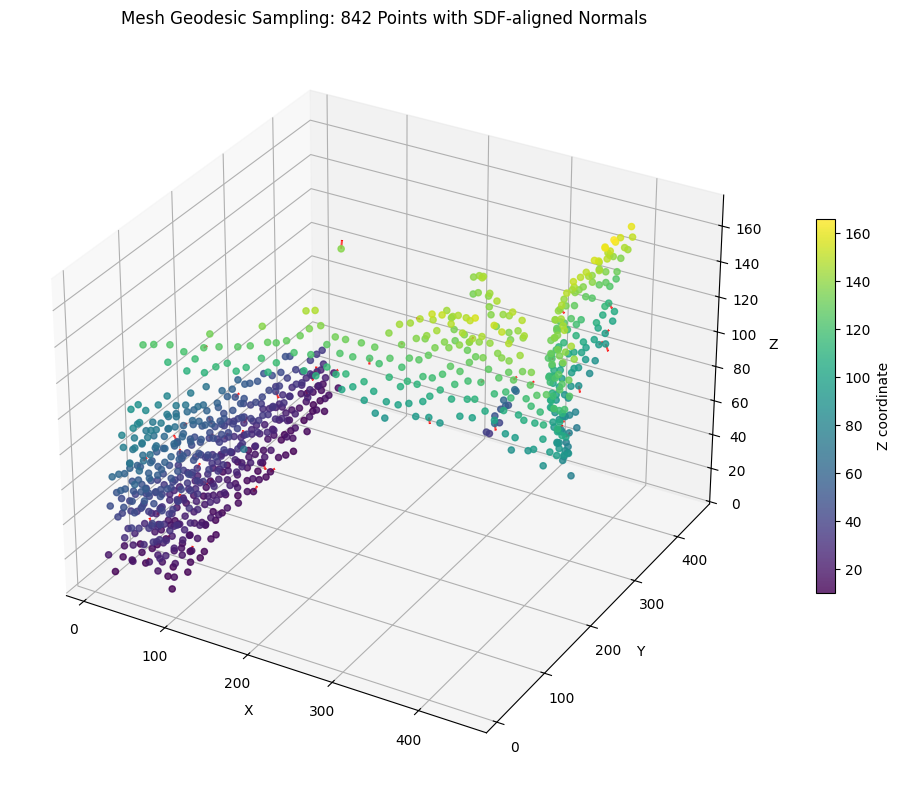

✅ 基础可视化完成 / Basic visualization completed
   显示点数 / Points displayed: 842
   箭头数 / Arrows displayed: 53


In [6]:
# =============================================================================
# 基础 3D 可视化 / Basic 3D Visualization
# =============================================================================

if len(centers) > 0:
    print("📊 生成基础 3D 可视化 / Generating basic 3D visualization")
    
    fig = plt.figure(figsize=(12, 8))
    
    # 3D 散点图
    ax = fig.add_subplot(111, projection='3d')
    
    # 绘制采样点
    scatter = ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], 
                        s=20, c=centers[:, 2], cmap='viridis', alpha=0.8)
    
    # 绘制法向量箭头（子采样以提高可读性）
    if len(centers) > 0:
        step = max(1, len(centers) // 50)  # 最多显示50个箭头
        sel = np.arange(0, len(centers), step)
        scale = 5.0
        
        ax.quiver(centers[sel, 0], centers[sel, 1], centers[sel, 2],
                  normals[sel, 0] * scale, normals[sel, 1] * scale, normals[sel, 2] * scale,
                  color='red', alpha=0.7, arrow_length_ratio=0.1)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Mesh Geodesic Sampling: {len(centers)} Points with SDF-aligned Normals')
    
    # 添加颜色条
    plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=20, label='Z coordinate')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ 基础可视化完成 / Basic visualization completed")
    print(f"   显示点数 / Points displayed: {len(centers)}")
    print(f"   箭头数 / Arrows displayed: {len(sel) if len(centers) > 0 else 0}")
else:
    print("⚠️  跳过可视化 / Skipping visualization (no points to display)")


📊 生成 mesh + 粒子的 3D 可视化 / Visualizing mesh with particles


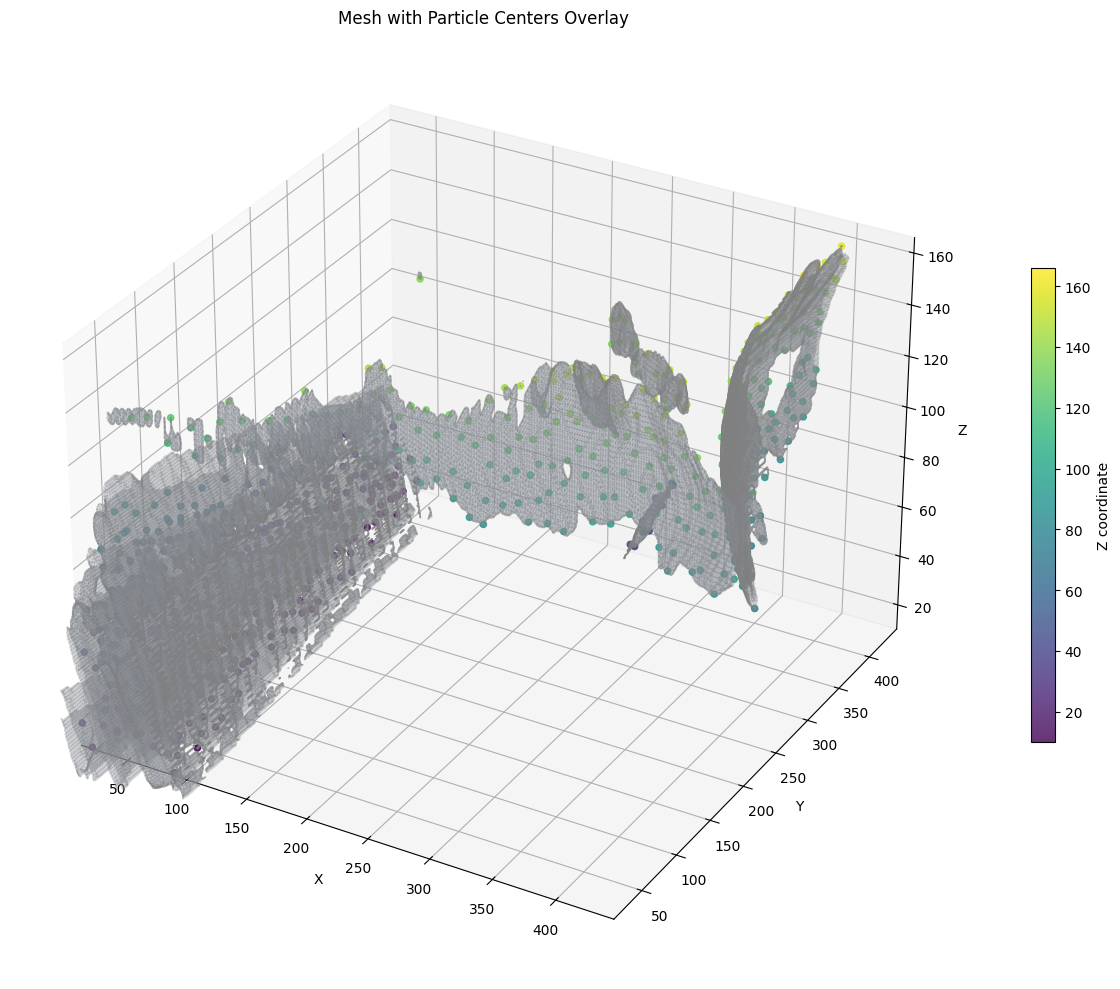

✅ mesh + 粒子 可视化完成 / Mesh + particles visualization done


In [7]:
# =============================================================================
# Mesh + Particles 可视化 / Visualize mesh with particles
# =============================================================================
if mesh is not None and len(centers) > 0:
    print("📊 生成 mesh + 粒子的 3D 可视化 / Visualizing mesh with particles")
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # 绘制 mesh（三角面，可半透明）
    # 统一构造三角面顶点坐标 (N, 3, 3)，以满足 Poly3DCollection 要求
    triangles = None
    if hasattr(mesh, "triangles") and hasattr(mesh, "vertices"):  # Open3D TriangleMesh
        _verts = np.asarray(mesh.vertices)
        _faces = np.asarray(mesh.triangles)
        if _verts.size > 0 and _faces.size > 0:
            triangles = _verts[_faces]  # (N, 3, 3)
    elif hasattr(mesh, "faces") and hasattr(mesh, "vertices"):  # Trimesh
        triangles = mesh.vertices[mesh.faces]

    if triangles is not None and len(triangles) > 0:
        from mpl_toolkits.mplot3d.art3d import Poly3DCollection
        mesh_collection = Poly3DCollection(triangles.tolist(), alpha=0.15)
        mesh_collection.set_facecolor("lightsteelblue")
        mesh_collection.set_edgecolor("gray")
        ax.add_collection3d(mesh_collection)
    else:
        print("⚠️  未找到mesh三角面数据 / Mesh faces not found")

    # 绘制粒子中心点
    scatter = ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], 
                        s=20, c=centers[:, 2], cmap='viridis', alpha=0.8, label='Particle centers')
    
    # 保证三维比例
    mesh_bbox = mesh.bounds if hasattr(mesh, "bounds") else None
    if mesh_bbox is not None:
        mins, maxs = mesh_bbox
        ax.set_xlim(mins[0], maxs[0])
        ax.set_ylim(mins[1], maxs[1])
        ax.set_zlim(mins[2], maxs[2])
    else:
        # 自动根据点设置范围
        xyz = np.vstack([centers])
        ax.set_xlim(np.min(xyz[:, 0]), np.max(xyz[:, 0]))
        ax.set_ylim(np.min(xyz[:, 1]), np.max(xyz[:, 1]))
        ax.set_zlim(np.min(xyz[:, 2]), np.max(xyz[:, 2]))

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Mesh with Particle Centers Overlay')
    plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=20, label='Z coordinate')
    plt.tight_layout()
    plt.show()
    print("✅ mesh + 粒子 可视化完成 / Mesh + particles visualization done")
else:
    print("⚠️  缺少 mesh 或采样点，跳过 mesh+particle 可视化 / Skipping mesh+centers overlay (missing mesh or centers)")



In [8]:
# =============================================================================
# 交互式 3D 可视化 / Interactive 3D Visualization
# =============================================================================

def plot_particles_interactive(coords: np.ndarray,
                               normals: np.ndarray,
                               *,
                               max_points_plot: int = 5000,
                               num_arrows: int = 800,
                               arrow_scale_frac: float = 0.05,
                               cone_radius_frac: float = 0.01,
                               marker_size: float = 2.0,
                               show_shafts: bool = True,
                               shaft_width: float = 2.0,
                               shaft_color: str = 'red') -> None:
    """
    创建交互式 3D 粒子可视化 / Create interactive 3D particle visualization
    """
    if coords is None or normals is None:
        raise ValueError('coords/normals cannot be None')
    if len(coords) == 0:
        raise ValueError('coords is empty')

    # 下采样以提高显示性能
    if len(coords) > max_points_plot:
        idx_pts = np.random.choice(len(coords), max_points_plot, replace=False)
        coords_vis = coords[idx_pts]
        normals_vis = normals[idx_pts]
    else:
        coords_vis = coords
        normals_vis = normals

    # 计算场景缩放
    data_extent = np.ptp(coords_vis, axis=0)
    max_range = float(np.max(data_extent)) if np.all(np.isfinite(data_extent)) and np.max(data_extent) > 0 else 1.0
    arrow_len = float(arrow_scale_frac) * max_range
    cone_radius = max(float(cone_radius_frac) * max_range, 1e-6)

    # 标准化法向量
    norms = np.linalg.norm(normals_vis, axis=1)
    safe_norms = np.where(norms > 0, norms, 1.0)
    normals_unit = normals_vis / safe_norms[:, None]

    # 创建点云
    points_trace = go.Scatter3d(
        x=coords_vis[:, 0], y=coords_vis[:, 1], z=coords_vis[:, 2],
        mode='markers',
        marker=dict(size=marker_size, color=coords_vis[:, 2], colorscale='Viridis', opacity=0.9),
        name='particles'
    )

    data = [points_trace]

    # 创建箭头（锥体）
    n_arrows = int(min(num_arrows, len(coords_vis)))
    if n_arrows > 0 and arrow_len > 0:
        arrow_idx = np.linspace(0, len(coords_vis) - 1, num=n_arrows, dtype=int)
        arrow_bases = coords_vis[arrow_idx]
        arrow_dirs = normals_unit[arrow_idx]

        u = arrow_dirs[:, 0] * arrow_len
        v = arrow_dirs[:, 1] * arrow_len
        w = arrow_dirs[:, 2] * arrow_len

        cones_trace = go.Cone(
            x=arrow_bases[:, 0], y=arrow_bases[:, 1], z=arrow_bases[:, 2],
            u=u, v=v, w=w,
            anchor='tail',
            colorscale='Reds', showscale=False,
            sizemode='absolute', sizeref=cone_radius,
            name='orientation',
            lighting=dict(ambient=0.6, diffuse=0.8, specular=0.2)
        )
        data.append(cones_trace)

        # 可选的箭头杆
        if show_shafts:
            xs = np.empty(3 * n_arrows)
            ys = np.empty(3 * n_arrows)
            zs = np.empty(3 * n_arrows)
            xs[0::3] = arrow_bases[:, 0]
            ys[0::3] = arrow_bases[:, 1]
            zs[0::3] = arrow_bases[:, 2]
            xs[1::3] = arrow_bases[:, 0] + u
            ys[1::3] = arrow_bases[:, 1] + v
            zs[1::3] = arrow_bases[:, 2] + w
            xs[2::3] = np.nan
            ys[2::3] = np.nan
            zs[2::3] = np.nan

            shafts_trace = go.Scatter3d(
                x=xs, y=ys, z=zs,
                mode='lines',
                line=dict(width=shaft_width, color=shaft_color),
                name='orientation_shaft',
                opacity=0.7
            )
            data.append(shafts_trace)

    fig = go.Figure(data=data)
    fig.update_layout(
        title=f'Interactive Particles: total={len(coords)} shown={len(coords_vis)}',
        scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z', aspectmode='data'),
        margin=dict(l=0, r=0, t=40, b=0)
    )
    fig.show()

# 调用交互式可视化
if len(centers) > 0:
    print("🎮 生成交互式 3D 可视化 / Generating interactive 3D visualization")
    plot_particles_interactive(
        centers, normals,
        max_points_plot=MAX_POINTS_PLOT,
        num_arrows=NUM_ARROWS,
        arrow_scale_frac=ARROW_SCALE_FRAC,
        cone_radius_frac=CONE_RADIUS_FRAC,
        marker_size=MARKER_SIZE,
        show_shafts=SHOW_SHAFTS,
        shaft_width=SHAFT_WIDTH,
        shaft_color=SHAFT_COLOR
    )
    print("✅ 交互式可视化完成 / Interactive visualization completed")
else:
    print("⚠️  跳过交互式可视化 / Skipping interactive visualization (no points to display)")


🎮 生成交互式 3D 可视化 / Generating interactive 3D visualization


✅ 交互式可视化完成 / Interactive visualization completed


In [9]:
# 在交互式3D展示中加入mesh

if 'mesh' in locals() and mesh is not None:
    # 添加membrane mesh到Plotly图形
    # mesh 是三角面片数据，需要 x, y, z 顶点坐标 和 I, J, K 三角索引
    vertices = np.asarray(mesh.vertices) if hasattr(mesh, 'vertices') else None
    faces = np.asarray(mesh.faces) if hasattr(mesh, 'faces') else None

    if vertices is not None and faces is not None:
        mesh_trace = go.Mesh3d(
            x=vertices[:, 0],
            y=vertices[:, 1],
            z=vertices[:, 2],
            i=faces[:, 0],
            j=faces[:, 1],
            k=faces[:, 2],
            name='membrane',
            color='lightblue',
            opacity=0.4,
            flatshading=True,
        )
        # plot_particles_interactive 里直接加 mesh_trace 到 data 列表
        # 但因为函数定义和调用已结束，只能单独绘制或重新绘制
        # 因此我们再展示一次带mesh的可交互plot

        def plot_particles_with_mesh(coords, normals, mesh, **kwargs):
            data = []
            # 先加入粒子和箭头
            plot_particles_interactive(
                coords, normals,
                **kwargs
            )
            # 再取上一幅交互可视化的Figure加mesh。不然就重构函数，联合添加
            # 这里直接画mesh
            mesh_trace = go.Mesh3d(
                x=vertices[:, 0],
                y=vertices[:, 1],
                z=vertices[:, 2],
                i=faces[:, 0],
                j=faces[:, 1],
                k=faces[:, 2],
                name='membrane',
                color='lightblue',
                opacity=0.4,
                flatshading=True,
            )
            # 仅mesh
            fig = go.Figure([mesh_trace])
            fig.update_layout(
                title=f"Membrane Mesh (only)",
                scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z', aspectmode='data'),
                margin=dict(l=0, r=0, t=40, b=0)
            )
            fig.show()

            # 粒子与mesh一同显示（重新组织data, 顺序确保mesh在下层）
            data = [mesh_trace]
            # 粒子与法向箭头
            n_plot = min(len(coords), kwargs.get('max_points_plot', 1000))
            coords_vis = coords[:n_plot]
            normals_vis = normals[:n_plot]
            marker_size = kwargs.get('marker_size', 3)
            scatter = go.Scatter3d(
                x=coords_vis[:, 0], y=coords_vis[:, 1], z=coords_vis[:, 2],
                mode='markers',
                name='particles',
                marker=dict(size=marker_size, color='red', opacity=0.7)
            )
            data.append(scatter)

            show_shafts = kwargs.get('show_shafts', True)
            num_arrows = kwargs.get('num_arrows', 100)
            arrow_scale_frac = kwargs.get('arrow_scale_frac', 0.2)
            shaft_width = kwargs.get('shaft_width', 3)
            shaft_color = kwargs.get('shaft_color', 'blue')
            if show_shafts:
                if len(normals_vis) > 0:
                    step = max(1, len(normals_vis) // num_arrows)
                    arrow_bases = coords_vis[::step]
                    arrow_dirs = normals_vis[::step]
                    n_arrows = len(arrow_bases)
                    arrow_lengths = np.linalg.norm(arrow_dirs, axis=1)
                    # 控制箭大小
                    lengths = arrow_scale_frac * (np.max(arrow_lengths) if np.max(arrow_lengths) > 0 else 1)
                    u, v, w = arrow_dirs[:,0]*lengths, arrow_dirs[:,1]*lengths, arrow_dirs[:,2]*lengths
                    xs = np.empty(3*n_arrows)
                    ys = np.empty(3*n_arrows)
                    zs = np.empty(3*n_arrows)
                    xs[0::3] = arrow_bases[:, 0]
                    ys[0::3] = arrow_bases[:, 1]
                    zs[0::3] = arrow_bases[:, 2]
                    xs[1::3] = arrow_bases[:, 0] + u
                    ys[1::3] = arrow_bases[:, 1] + v
                    zs[1::3] = arrow_bases[:, 2] + w
                    xs[2::3] = np.nan
                    ys[2::3] = np.nan
                    zs[2::3] = np.nan
                    shafts_trace = go.Scatter3d(
                        x=xs, y=ys, z=zs,
                        mode='lines',
                        line=dict(width=shaft_width, color=shaft_color),
                        name='orientation_shaft',
                        opacity=0.7
                    )
                    data.append(shafts_trace)
            fig = go.Figure(data=data)
            fig.update_layout(
                title=f'Particles + Mesh: total={len(coords)} shown={len(coords_vis)}',
                scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z', aspectmode='data'),
                margin=dict(l=0, r=0, t=40, b=0)
            )
            fig.show()

        print("🎮 生成包含mesh的交互式3D可视化 / Generating interactive 3D visualization WITH membrane mesh")
        plot_particles_with_mesh(
            centers, normals, mesh,
            max_points_plot=MAX_POINTS_PLOT,
            num_arrows=NUM_ARROWS,
            arrow_scale_frac=ARROW_SCALE_FRAC,
            marker_size=MARKER_SIZE,
            show_shafts=SHOW_SHAFTS,
            shaft_width=SHAFT_WIDTH,
            shaft_color=SHAFT_COLOR
        )



In [10]:
# =============================================================================
# ChimeraX 可视化生成 / ChimeraX Visualization Generation
# =============================================================================

if len(centers) > 0 and 'star_file' in locals():
    print("🎨 生成 ChimeraX 可视化脚本 / Generating ChimeraX visualization script")
    
    # 生成 ChimeraX 脚本
    cxc_file = Path(OUTPUT_DIR) / f"{TOMOGRAM_NAME}_particles.cxc"
    write_cxc_for_particles(
        star_file,
        cxc_file,
        sphere_radius=SPHERE_RADIUS,
        arrow_length=ARROW_LENGTH,
        coordinate_scale=COORDINATE_SCALE,
        arrow_axis=ARROW_AXIS,
        sphere_color=SPHERE_COLOR,
        arrow_color=ARROW_COLOR
    )
    
    print(f"✅ ChimeraX 脚本生成完成 / ChimeraX script generated")
    print(f"   脚本文件 / Script file: {cxc_file}")
    print(f"   查看命令 / View command: chimerax {cxc_file}")
    
    # 验证转换精度
    print("\n🔍 验证法向量转换精度 / Verifying normal vector conversion accuracy")
    try:
        df = read_star(star_file)
        parsed = parse_particles_from_star(df)
        eulers = parsed['eulers']
        
        # 测试前几个粒子的转换精度
        errors = []
        test_count = min(5, len(centers))
        
        for i in range(test_count):
            original_normal = normals[i]
            tilt, psi, rot = eulers[i]
            converted_direction = RELIONConverter.rotation_matrix_to_direction(tilt, psi, rot, axis='z')
            error = np.linalg.norm(original_normal - converted_direction)
            errors.append(error)
            print(f"   粒子 {i+1} / Particle {i+1}: 误差 / Error = {error:.6f}")
        
        avg_error = np.mean(errors)
        print(f"   平均转换误差 / Average conversion error: {avg_error:.6f}")
        
        if avg_error < 1e-5:
            print("   ✅ 转换精度很高 / Conversion is highly accurate!")
        elif avg_error < 0.1:
            print("   ✅ 转换精度良好 / Conversion accuracy is good")
        else:
            print("   ⚠️  转换存在误差 / Conversion has some error")
            
    except Exception as e:
        print(f"   ⚠️  转换验证失败 / Conversion verification failed: {e}")
        
else:
    print("⚠️  跳过 ChimeraX 可视化 / Skipping ChimeraX visualization (no points or STAR file)")


🎨 生成 ChimeraX 可视化脚本 / Generating ChimeraX visualization script
Available columns in STAR file: ['rlnCoordinateX', 'rlnCoordinateY', 'rlnCoordinateZ', 'rlnAngleTilt', 'rlnAnglePsi', 'rlnAngleRot', 'rlnTomoName', 'rlnTomoParticleId', 'rlnTomoParticleDiameter']
Extracted 842 particles with 842 angle sets
First particle angles: tilt=56.76, psi=16.79, rot=0.00
First particle coordinates: x=10.10, y=232.16, z=22.22
Particle 0: angles=(56.76, 16.79, 0.00), direction=(0.836, 0.000, 0.548)
Particle 1: angles=(31.06, -0.36, 0.00), direction=(0.516, 0.000, 0.857)
Particle 2: angles=(57.47, 4.26, 0.00), direction=(0.843, 0.000, 0.538)
✅ ChimeraX 脚本生成完成 / ChimeraX script generated
   脚本文件 / Script file: ../results/particle_visualization_demo/demo_tomo_particles.cxc
   查看命令 / View command: chimerax ../results/particle_visualization_demo/demo_tomo_particles.cxc

🔍 验证法向量转换精度 / Verifying normal vector conversion accuracy
   粒子 1 / Particle 1: 误差 / Error = 0.244281
   粒子 2 / Particle 2: 误差 / Error = 0.0

/home/muwang/Documents/GitHub/TomoPANDA/tomopanda/utils/relion_utils.py:430: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead

/home/muwang/Documents/GitHub/TomoPANDA/tomopanda/utils/relion_utils.py:430: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



In [11]:
# =============================================================================
# 统计分析和总结 / Statistical Analysis and Summary
# =============================================================================

if len(centers) > 0:
    print("📈 统计分析 / Statistical Analysis")
    print("=" * 50)
    
    # 基本统计
    print(f"📊 基本统计 / Basic Statistics:")
    print(f"   总采样点数 / Total sampled points: {len(centers)}")
    print(f"   坐标范围 / Coordinate ranges:")
    print(f"     X: [{centers[:, 0].min():.2f}, {centers[:, 0].max():.2f}] (范围 / Range: {centers[:, 0].max() - centers[:, 0].min():.2f})")
    print(f"     Y: [{centers[:, 1].min():.2f}, {centers[:, 1].max():.2f}] (范围 / Range: {centers[:, 1].max() - centers[:, 1].min():.2f})")
    print(f"     Z: [{centers[:, 2].min():.2f}, {centers[:, 2].max():.2f}] (范围 / Range: {centers[:, 2].max() - centers[:, 2].min():.2f})")
    
    # 法向量统计
    normal_norms = np.linalg.norm(normals, axis=1)
    print(f"\n🧭 法向量统计 / Normal Vector Statistics:")
    print(f"   平均长度 / Mean length: {normal_norms.mean():.6f}")
    print(f"   标准差 / Standard deviation: {normal_norms.std():.6f}")
    print(f"   最小长度 / Minimum length: {normal_norms.min():.6f}")
    print(f"   最大长度 / Maximum length: {normal_norms.max():.6f}")
    
    # 角度统计
    z_axis = np.array([0.0, 0.0, 1.0])
    cos_tilt = np.sum(normals * z_axis, axis=1)
    tilt_angles = np.degrees(np.arccos(np.clip(cos_tilt, -1.0, 1.0)))
    
    print(f"\n📐 角度统计 / Angle Statistics:")
    print(f"   Tilt 角度范围 / Tilt angle range: [{tilt_angles.min():.1f}°, {tilt_angles.max():.1f}°]")
    print(f"   平均 Tilt 角度 / Mean tilt angle: {tilt_angles.mean():.1f}°")
    print(f"   Tilt 角度标准差 / Tilt angle std: {tilt_angles.std():.1f}°")
    
    # 采样密度
    if len(centers) > 1:
        from scipy.spatial.distance import pdist
        distances = pdist(centers)
        print(f"\n📏 采样密度 / Sampling Density:")
        print(f"   平均最近邻距离 / Mean nearest neighbor distance: {distances.min():.2f}")
        print(f"   平均距离 / Mean distance: {distances.mean():.2f}")
        print(f"   最大距离 / Maximum distance: {distances.max():.2f}")
    
    print(f"\n✅ 分析完成 / Analysis completed")
    
else:
    print("⚠️  跳过统计分析 / Skipping statistical analysis (no points to analyze)")


📈 统计分析 / Statistical Analysis
📊 基本统计 / Basic Statistics:
   总采样点数 / Total sampled points: 842
   坐标范围 / Coordinate ranges:
     X: [10.10, 445.40] (范围 / Range: 435.30)
     Y: [10.42, 445.60] (范围 / Range: 435.18)
     Z: [10.01, 165.89] (范围 / Range: 155.88)

🧭 法向量统计 / Normal Vector Statistics:
   平均长度 / Mean length: 1.000000
   标准差 / Standard deviation: 0.000000
   最小长度 / Minimum length: 1.000000
   最大长度 / Maximum length: 1.000000

📐 角度统计 / Angle Statistics:
   Tilt 角度范围 / Tilt angle range: [2.3°, 174.9°]
   平均 Tilt 角度 / Mean tilt angle: 72.3°
   Tilt 角度标准差 / Tilt angle std: 32.9°

📏 采样密度 / Sampling Density:
   平均最近邻距离 / Mean nearest neighbor distance: 10.00
   平均距离 / Mean distance: 247.65
   最大距离 / Maximum distance: 588.75

✅ 分析完成 / Analysis completed


## 总结 / Summary

### 🎯 本 Notebook 功能 / Features of this Notebook

1. **CLI 参数配置** - 所有参数集中在文件顶部，便于调整
2. **MRC 掩码可视化** - 显示原始膜掩码的切片和投影
3. **SDF 生成和可视化** - 签名距离场的生成和可视化
4. **网格提取和统计** - 从 SDF 提取三角网格并分析质量
5. **Mesh Geodesic 采样** - 使用最新的网格面采样方法
6. **多种可视化方式**:
   - 基础 3D matplotlib 可视化
   - 交互式 Plotly 3D 可视化  
   - ChimeraX 专业可视化脚本
7. **统计分析** - 详细的采样结果统计
8. **文件输出** - 标准 RELION 格式输出

### 🔧 使用方法 / Usage

1. **调整参数**: 修改第一个 cell 中的 CLI 参数
2. **运行所有 cells**: 按顺序执行所有代码块
3. **查看结果**: 
   - 在 notebook 中查看交互式可视化
   - 使用 ChimeraX 查看专业可视化: `chimerax {output_dir}/{tomogram_name}_particles.cxc`
   - 检查输出文件: `{output_dir}/` 目录

### 📁 输出文件 / Output Files

- `sampling_coordinates.csv` - 采样坐标和法向量
- `particles.star` - RELION STAR 格式
- `coordinates.csv` - 坐标文件
- `prior_angles.csv` - 角度先验
- `{tomogram_name}_particles.cxc` - ChimeraX 可视化脚本
- `visualize_results.py` - matplotlib 可视化脚本（可选）

### 🎨 可视化特点 / Visualization Features

- **MRC 掩码可视化**: 原始膜掩码的切片和3D投影显示
- **SDF 可视化**: 签名距离场的发散色彩映射显示（负值蓝色，0白色，正值红色）
- **网格质量分析**: 三角形面积统计和网格质量指标
- **SDF 对齐法向量**: 法向量方向与 SDF 梯度一致，指向膜外
- **多种显示方式**: 点云、箭头、锥体等
- **交互式操作**: 缩放、旋转、平移
- **专业输出**: ChimeraX 兼容格式
